# Results report

We use this notebook to store the results of the multiple benchmarks that were run on the algorithms implemented. Details will be added alongside the tests results.

In [1]:
# Execute this cell first if you want to run the tests
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

from project.policy import RandomPolicy
from project.oracle import Oracle
from project.bandit import Bandit, BernouilliArm

The cell below is used to define the benchmark being run.

In [2]:
# Policies definitions
policies = {
    'random': RandomPolicy(),
}

# Bandits definition
null_bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.3},
        {'p': 0.3},
    )
)

alt_bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.3},
        {'p': 0.5},
    )
)

# Construct Oracle
oracle = Oracle(policies=policies.values())

The following cell will run both simulations for the null and the alternative hypotheses.

In [3]:
# Benchmark definition
n_runs = 400
n_steps = 148
seed = None  # set a seed for reproducible results

# Store results for both hypotheses simulations
oracle.set_bandit(null_bandit)
null_report = oracle.evaluate(
    n_runs=n_runs,
    run_length=n_steps,
    seed=seed
)
oracle.set_bandit(alt_bandit)
alt_report = oracle.evaluate(
    n_runs=n_runs,
    run_length=n_steps,
    seed=seed
)

In [4]:
# Small utility for plotting results from both reports
def _plot(plot_fun):
    plot_fun(null_report, label='H0')
    plot_fun(alt_report, label='H1')
    plt.legend()

---

## Reward and regret

We first consider the following metrics of performance:

- **Expected Total Discounted**, or **ETD**, as used in the article:

$$\sum_t \sum_k d^t r_{k,t} a_{k,t}$$

- **Expected Reward** at a given timestep $t$, and its cumulative sum, the **Expected Number of Successes** (ENS)
- **Expected Total Regret** (where $p^*$ is the best arm's probability of success, and $r_t = \sum_k r_{k,t} a_{k,t}$:

$$T \cdot p^* - \sum_t r_t$$

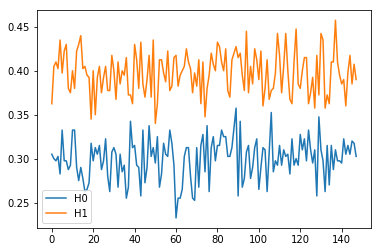

In [5]:
# Expected Reward at time t
def plot_exp_reward(report, **kwargs):
    observed_rewards = report.results[:, 0, :]
    expected_reward = np.mean(observed_rewards, axis=0)

    plt.plot(expected_reward, **kwargs)


_plot(plot_exp_reward)

In [7]:
# Expected Number of Successes at final timestep
def print_ens(report):
    obs = report.results[:, 0, :]
    ns = np.sum(obs, axis=1)
    ens = np.mean(ns)
    ens_se = np.std(ns)

    print('ENS = {:.2f} ({:.2f})'.format(ens, ens_se))

print_ens(null_report)
print_ens(alt_report)

ENS = 44.38 (5.52)
ENS = 58.84 (5.88)


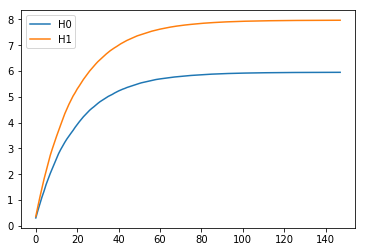

In [8]:
# Expected Total Discounted reward at time t

# Set discount value here
discount = 0.95

def plot_etd(report, **kwargs):
    obs = report.results[:, 0, :]
    exp = np.mean(obs, axis=0)
    etd = np.cumsum([
        discount ** t * exp[t]
        for t in range(n_steps)
    ])

    plt.plot(etd, **kwargs)

_plot(plot_etd)

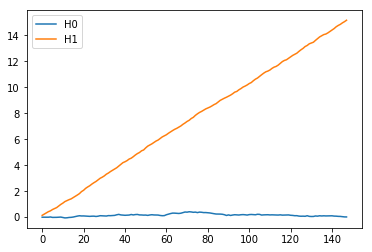

In [11]:
# Expected Total Regret at time t

def plot_etr(report, **kwargs):
    obs = report.results[:, 0, :]
    exp = np.mean(obs, axis=0)
    
    best_arm = max(arm.p for arm in report.bandit.arms)
    etr = np.cumsum(best_arm - exp)

    plt.plot(etr, **kwargs)

_plot(plot_etr)